In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://junstar92.tistory.com/121   참고

In [ ]:
# 소규모 이미지 데이터셋 이진분류 체크

# 추가 확인 필요 :
# 마지막 계층 변경 체크
# 학습 참여 계층 체크

[Pytorch][Kaggle] Cats vs. Dogs Classification

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import shutil
import zipfile
import glob
import os
import time

압축해제

In [3]:
import zipfile

zip_file = zipfile.ZipFile('/content/drive/MyDrive/Request_check/Binary_clf/ant_bee_small_dataset/ant_bee3.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('/content/ant_bee3/') # 압축을 해제할 '/위치경로/'

In [4]:
os.getcwd()

'/content'

In [5]:
data_dir = os.path.join(os.getcwd(), 'ant_bee3')

train_set_dir = os.path.join(data_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(data_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(data_dir, 'test')
os.mkdir(test_set_dir)

In [6]:
data_dir

'/content/ant_bee3'

In [7]:
ant_files = ['ant{0:03d}.jpg'.format(i+1) for i in range(193)] # 001~193
bee_files = ['bee{0:03d}.jpg'.format(i+1) for i in range(204)] # 001~204

In [8]:
# 7:2:1 / train:valid:test
# ant
# 135:38:20
# bee
# 143:41:20

In [9]:
# train dataset [10:7]
# 001~135, 001~143             # 278개
for ant in ant_files[:135]:
    src = os.path.join(data_dir, ant)
    dst = os.path.join(train_set_dir, ant)
    shutil.move(src, dst)

for bee in bee_files[:143]:
    src = os.path.join(data_dir, bee)
    dst = os.path.join(train_set_dir, bee)
    shutil.move(src, dst)

# valid dataset [10:2]
# 136~173, 144~184            # 79개
for ant in ant_files[135:173]:
    src = os.path.join(data_dir, ant)
    dst = os.path.join(valid_set_dir, ant)
    shutil.move(src, dst)

for bee in bee_files[143:184]:
    src = os.path.join(data_dir, bee)
    dst = os.path.join(valid_set_dir, bee)
    shutil.move(src, dst)

# test dataset [10:1]
# 174~193, 185~204            # 40개
for ant in ant_files[173:193]:
    src = os.path.join(data_dir, ant)
    dst = os.path.join(test_set_dir, ant)
    shutil.move(src, dst)

for bee in bee_files[184:204]:
    src = os.path.join(data_dir, bee)
    dst = os.path.join(test_set_dir, bee)
    shutil.move(src, dst)

In [10]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validn set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 278
the number of validn set : 79
the number of test set : 40


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform

        if 'ant' in files[0]:
            self.label = 0
        else:
            self.label = 1

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))

        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [12]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

In [13]:
train_ant_dataset = CustomDataset(ant_files[:135], train_set_dir, transform=train_transform)
train_bee_dataset = CustomDataset(bee_files[:143], train_set_dir, transform=train_transform)
valid_ant_dataset = CustomDataset(ant_files[135:173], valid_set_dir, transform=test_transform)
valid_bee_dataset = CustomDataset(bee_files[143:184], valid_set_dir, transform=test_transform)
test_ant_dataset = CustomDataset(ant_files[173:], test_set_dir, transform=test_transform)
test_bee_dataset = CustomDataset(bee_files[184:], test_set_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_ant_dataset, train_bee_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_ant_dataset, valid_bee_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_ant_dataset, test_bee_dataset])


In [14]:
print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

number of train dataset : 278
number of valid dataset : 79
number of test dataset : 40


[DataLoader] 학습/평가에 사용

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

[DataLoader] 정상 작동 확인

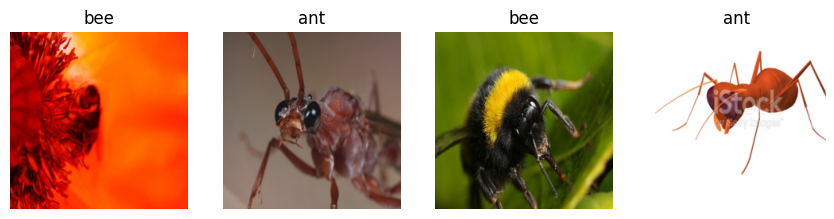

In [16]:
samples, labels = next(iter(train_loader))
classes = {0:'ant', 1:'bee'}
fig = plt.figure(figsize=(16,24))
for i in range(4):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## Model

In [17]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
model = torchvision.models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [20]:
num_ftrs

512

In [24]:
model.fc

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=1024, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=512, out_features=1, bias=True)
  (6): Sigmoid()
)

In [ ]:
from torchsummary import summary

In [ ]:
model.cuda()
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Training

In [ ]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

4.058sec : [Epoch 1/100] -> train loss: 0.6841, train acc: 55.396% / valid loss: 0.5820, valid acc: 88.608%
3.168sec : [Epoch 2/100] -> train loss: 0.5718, train acc: 75.180% / valid loss: 0.4743, valid acc: 89.873%
3.937sec : [Epoch 3/100] -> train loss: 0.5254, train acc: 75.540% / valid loss: 0.3911, valid acc: 92.405%
3.158sec : [Epoch 4/100] -> train loss: 0.4070, train acc: 85.252% / valid loss: 0.3198, valid acc: 92.405%
3.167sec : [Epoch 5/100] -> train loss: 0.3431, train acc: 87.050% / valid loss: 0.2763, valid acc: 92.405%
3.095sec : [Epoch 6/100] -> train loss: 0.3325, train acc: 86.331% / valid loss: 0.2627, valid acc: 89.873%
3.820sec : [Epoch 7/100] -> train loss: 0.2666, train acc: 89.568% / valid loss: 0.3228, valid acc: 81.013%
3.147sec : [Epoch 8/100] -> train loss: 0.2547, train acc: 91.007% / valid loss: 0.2538, valid acc: 86.076%
3.142sec : [Epoch 9/100] -> train loss: 0.3024, train acc: 88.849% / valid loss: 0.2020, valid acc: 92.405%
3.291sec : [Epoch 10/100] ->

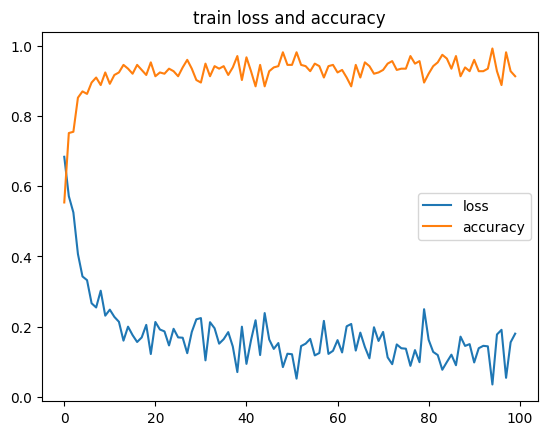

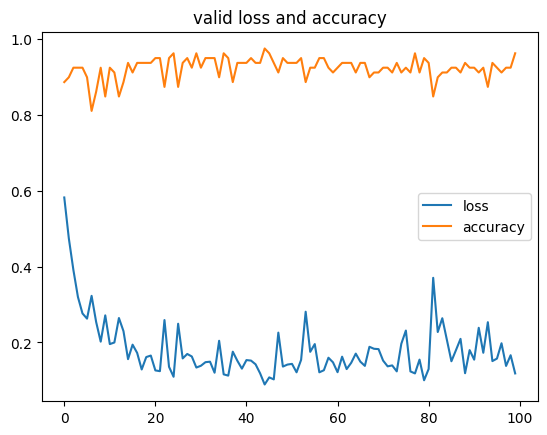

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
epoch = 100

fit(model, criterion, optimizer, epoch, train_loader, valid_loader)

## 모델 평가

In [ ]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0

            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')


In [ ]:
eval(model, criterion, test_loader)

eval loss: 0.1725, eval acc: 95.000%
